In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.integrate as spint
import scipy.interpolate as spinterp
'''Karan Kumar 14906619'''

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'Karan Kumar 14906619'

In [2]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
stars.columns


Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS'],
      dtype='object')

Filter stars by high proability P > 0.8

In [4]:
stars_hiprob = stars[stars.Prob > 0.8]
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='count')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()

In [60]:
def per_cluster(hiprob_data):
    '''Calculate 6 parameters of  cluster
    n - number of stars in a cluster
    omega- mean parallax of the cluster
    sigma - standard deviation of the paralax
    size - size of cluster
    proper_motion_mag- mean proper motion of cluster
    proper_motion_std - standard deviaion of the propermotion

    
    input:
    hiprob_data - pd dataframe of stars with high probability 
    
    variables:
    filtered_dataframe - pd dataframe append parameters into and return
    clusters- find all the clusters in the dataframe with a common name
    
    return 
    filtered dataframe with 6 calculated parameters per cluster'''
    
    #find the unique cluster names in the dataframe
    filtered_dataframe = pd.DataFrame()
   #group each cluster by its name
    #all operations should applied on this variable name
    clusters = hiprob_data.groupby('Name') #so i don't have to keep writing this
    
    n  = clusters.size()
    filtered_dataframe['Counts'] = n

    plx_method = clusters['Plx'].mean()
    filtered_dataframe['Mean plx'] = plx_method

    plx_std = clusters['Plx'].std(numeric_only=True)
    filtered_dataframe['Plx std'] = plx_std

    size = np.sqrt(clusters['RAdeg'].std()**2  + clusters['DEdeg'].std()**2)
    filtered_dataframe["Cluster Size"] = size

    proper_motion_mag = (clusters['pmRA'].mean())**2 + (clusters['pmDE'].mean())**2
   # proper_motion_mag = #clusters['pmRA'].transform(lambda x:x**2)  + clusters['pmDE'].transform(lambda y:y**2)
    proper_motion_mag = np.sqrt(proper_motion_mag)
    filtered_dataframe["Mean PM" ] = proper_motion_mag

    proper_motion_std = np.sqrt(clusters['pmRA'].std()**2  + clusters['pmDE'].std()**2)
    filtered_dataframe["PM Std"] = proper_motion_std
    
    return filtered_dataframe
cluster_analysis = per_cluster(stars_hiprob)
#i get a warning becuase im running operations on a copy of a original dataframe, but it still works
cluster_analysis


,Counts,Mean plx,Plx std,Cluster Size,Mean PM,PM Std
Name,,,,,,
1636-283,30,0.126939,0.034519,0.050512,6.650466,0.240161
ADS_16795,41,4.759659,0.101591,5.438194,18.871288,1.810880
AH03_J0748+26.9,28,0.210004,0.017010,0.045579,4.025658,0.048521
ASCC_100,87,2.748023,0.091920,1.240143,3.863448,0.557090
ASCC_101,149,2.517671,0.088908,1.027157,1.595839,0.444430
...,...,...,...,...,...,...
vdBergh_152,25,2.674800,0.029313,0.886879,5.349199,0.444215
vdBergh_80,93,1.001419,0.053363,0.425505,3.299538,0.375063
vdBergh_83,92,1.041742,0.095341,0.347059,4.355737,0.277022


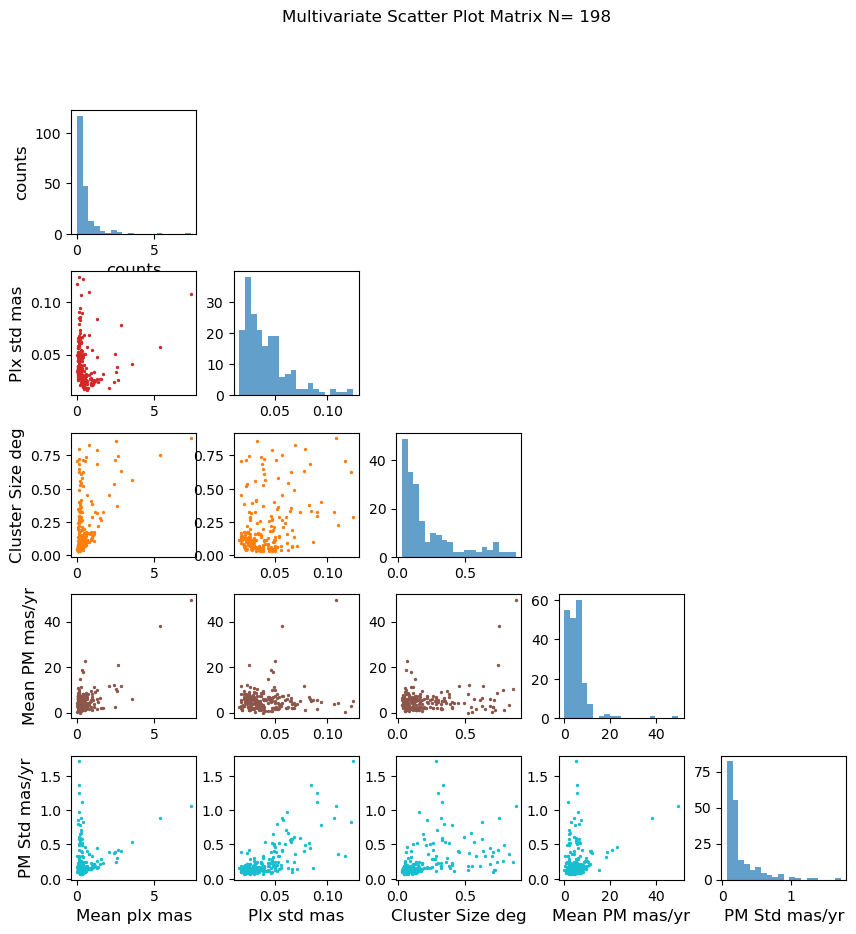

In [61]:
def scatter_matrix(cluster):
    '''Create a mulitvariate matrix of a dataframe of clusters
    
     i took all of this code from my first assignment submission
     and modified it to read the data for this assignment.

     input:
     cluster- dataframe of star clusters

     variables:
     data - df column, parameters to plot
     labels- axes labels, also related to parameters to plot
     return
     multivariate scatter matrix of parameters from data 
    '''
    
    counts = 200
    max_val = 1.0 
    #filter clusters by counts and size
    cluster = cluster[cluster['Counts'] > 200]
    cluster = cluster[cluster['Cluster Size'] < 1.0]
    #ignore counts column
    labels= cluster.columns[1:] 
    units = ['mas', 'mas','deg','mas/yr','mas/yr'] # add units to the labels
    data = [cluster['Mean plx'], cluster['Plx std'], cluster['Cluster Size'], cluster['Mean PM'], cluster['PM Std']]
    ndims = len(data)
    fig, axes = plt.subplots(5,5,figsize=(10,10))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("Multivariate Scatter Plot Matrix N= "+str(len(cluster)))
    colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:brown', 'tab:cyan']
    for i in range(ndims): ## y dimension of grid
        for j in range(ndims): ## x dimension of grid
            if i == j:
                axes[i,j].hist(data[i], bins=20,alpha=0.7,)
            elif i > j:
                axes[i,j].scatter(data[j], data[i],s=2, color=colors[i])
            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_xlabel('counts',fontsize=12)
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i]+' '+units[i],fontsize=12)
            if i == 4:
                axes[i,j].set_xlabel(labels[j]+' '+units[j],fontsize=12)    
    #fig.legend(labels=labels)
    plt.show()
    return cluster
cluster_analysis = scatter_matrix(cluster_analysis)

# Visual Correlations
Here im just looking for linear trends by eye starting from the bottom row, looking up <br>
Mean plx and Mean PM, Cluster Size <br>
Plx std and PM std, Mean PM <br>
Cluster size and PM std, Mean PM

In [7]:
cluster_analysis# filtered clusters

,Counts,Mean plx,Plx std,Cluster Size,Mean PM,PM Std
Name,,,,,,
BH_131,227,0.125637,0.046214,0.221680,6.536827,0.154404
BH_140,338,0.190195,0.043486,0.127424,14.897046,0.129645
BH_66,355,0.123089,0.044962,0.180838,5.470541,0.229493
Berkeley_36,217,0.217359,0.065872,0.063243,1.967901,0.099389
Berkeley_39,211,0.226982,0.038289,0.045639,2.371439,0.068647
...,...,...,...,...,...,...
UBC_461,231,0.298768,0.031775,0.419239,4.096675,0.109858
UBC_517,256,0.405671,0.022682,0.716871,5.685520,0.127498
UBC_600,390,0.171171,0.039550,0.721515,1.191558,0.134289


I've filtered down to 198 clusters

In [8]:
def correlation(df_col1, df_col2):
    '''Calculate a pearson r and spearman rho correlation' for two dataframe columns
    '''
    r_val, p_val_r = sps.pearsonr(df_col1, df_col2)
    rho_val, p_val_rho = sps.spearmanr(df_col1, df_col2)
    return r_val, p_val_r, rho_val, p_val_rho

#i did the enumerate loop and asked chatgpt how to print everything to 4 sig digits

for i, cols1 in enumerate(cluster_analysis.columns[1:]): #skip counts column
    for j, cols2 in enumerate(cluster_analysis.columns[1:]):
        if i < j :
            pearson_corr, pearson_p_value, spearman_corr, spearman_p_value = correlation(cluster_analysis[cols1], cluster_analysis[cols2])
            print(f"{cols1} vs {cols2}: Pearson Correlation = {pearson_corr:.4f} (p-value = {pearson_p_value}), Spearman Correlation = {spearman_corr:.4f} (p-value = {spearman_p_value})")


Mean plx vs Plx std: Pearson Correlation = 0.0476 (p-value = 0.5053546796704824), Spearman Correlation = -0.3762 (p-value = 4.712016719689901e-08)
Mean plx vs Cluster Size: Pearson Correlation = 0.4766 (p-value = 1.275929198033422e-12), Spearman Correlation = 0.3736 (p-value = 5.8970560488021756e-08)
Mean plx vs Mean PM: Pearson Correlation = 0.6685 (p-value = 5.222065852850052e-27), Spearman Correlation = 0.0513 (p-value = 0.4729721146639403)
Mean plx vs PM Std: Pearson Correlation = 0.2285 (p-value = 0.0012062465572070208), Spearman Correlation = 0.0252 (p-value = 0.7242272544725276)
Plx std vs Cluster Size: Pearson Correlation = 0.3413 (p-value = 8.621711563390255e-07), Spearman Correlation = 0.2088 (p-value = 0.003160198292861663)
Plx std vs Mean PM: Pearson Correlation = 0.1291 (p-value = 0.06980530934800966), Spearman Correlation = -0.0134 (p-value = 0.8513928555765554)
Plx std vs PM Std: Pearson Correlation = 0.7130 (p-value = 4.7609372509091034e-32), Spearman Correlation = 0.60

You can improve the situation by performing the tests on log-transformed data (i.e. on the
logarithm of the quantities instead of the original values). Why should this make the tests
more reliable? Finally, comment on your results and their implications

Log transforming would reduce the problem of mulitplying over small floats for both tests. Multiplying the terms in each correlation test for small values is computatuionally difficult and long especially for large datapoints. Logspacing the data would make it more reliable because you reduce multipication error and computational time

For each Correlation a value of [-1,1] is assigned to the test. ) 0 is no correlation, -1 is negative correlation i.e. as x increases, y decreases. +1 is posiitive correlation.as x increases, y increases. Pearson-r looks for a linear relation. Spearman-rho looks for monotonic relation.

Each correlation test calculates a null hypothesis that the data is unrelated. A low p value means we can confidently reject the null hypothesis

# Spearman $\rho$
Values with a monotonic correlation and high confidence 
<ol>
  <li>Mean plx and Mean PM.</li>
  <li>Plx std and PM std</li>
    <li>Cluster Size and PM std</li>
</ol>

## Pearson R
Values with a linear correlation and high confidence
<ol>
  <li>Mean plx and Mean Cluster Size</li>
  <li>Mean plx and Mean PM </li>
    <li>Mean plx and PM std</li>
    <li>Plx std and Cluster size</li>
    <li>Plx std and PM std</li>
    <li>Cluster size and PM std</li>
    <li>Mean PM and PM std</li>
</ol>

### Explanation
Spearman $\rho$ tells us that monotonically realted variables can also be linearly related by Pearson r. But not naviely the other way around. The mean plx correlations make sense since we rely on parallax to make these measurements

In [9]:
stars.columns

Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS'],
      dtype='object')

In [10]:

def realitstic_prior(d):
    '''Calculate an exponetial prior for distance'''
    L = 1.0
    return (d**2)*np.exp(-d/L)

# Probability Distribution Function
I want to calculate a fit to the model parameters of parallax assuming a normal distribution
$$P(\theta)| D) = \frac{P(D| \theta)P(\theta)}{P(D)} $$
Where $P(\theta) = Constant$ or the exporential term in the assignment given by the function realistic_prior and $P(D | \theta) $ is a normal distribution

$$P(D| \theta) = \frac{exp{\frac{-x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}}$$
Where $\mu$ and $\sigma^2$ are the mean and standard deviation of the parallax respectivley. For the analysis this is converted to distance in kpc. And the denominator term
$$P(D) = \int P(D| \theta)P(\theta)$$ 

# Method
Select a random cluster with more than 200 memebers and low std <br>
Derive the distance to each star in the cluster as well as the meand and std dev <br>
calculate the posterior in two cases, uniform prior and exponential prior
return the two posteriors
## Assumptions
$P(D| \theta)$ is a normal distribution <br>
$\theta$ includes the mean and standard deviation of the distance <br>
The distance to the cluster comes from the stars within the cluster and calculate by thier mean <br>
The uniform prior is divided out because it's a constant so its choice is arbitrary-  i assume its given by the mean distance <br>

In [11]:
#get the names of all the clusters 
for names in cluster_analysis.index:
    print(names)

BH_131
BH_140
BH_66
Berkeley_36
Berkeley_39
Berkeley_43
Bochum_1
Bochum_10
Collinder_110
Collinder_261
Collinder_394
Collinder_419
Collinder_69
Czernik_41
Dolidze_32
FSR_0167
FSR_1758
FoF_145
Gulliver_15
HSC_1181
HSC_1355
HSC_1593
HSC_179
HSC_186
HSC_1890
HSC_2016
HSC_2061
HSC_2138
HSC_2359
HSC_2363
HSC_2667
HSC_280
HSC_287
HSC_2878
HSC_2879
HSC_290
HSC_2939
HSC_2950
HSC_299
HSC_31
HSC_338
HSC_358
HSC_38
HSC_561
HSC_631
HSC_639
HSC_640
HSC_647
HSC_650
HSC_655
HSC_955
IC_2714
IC_4651
IC_4725
Juchert_10
King_7
Kronberger_52
Melotte_105
Melotte_22
Melotte_66
Melotte_71
NGC_1647
NGC_1817
NGC_1851
NGC_188
NGC_1912
NGC_2099
NGC_2112
NGC_2141
NGC_2158
NGC_2168
NGC_2287
NGC_2301
NGC_2323
NGC_2345
NGC_2360
NGC_2437
NGC_2447
NGC_2477
NGC_2506
NGC_2516
NGC_2547
NGC_2548
NGC_2632
NGC_2660
NGC_2682
NGC_2808
NGC_288
NGC_3114
NGC_3201
NGC_3532
NGC_3603
NGC_362
NGC_3766
NGC_4372
NGC_4590
NGC_4755
NGC_4815
NGC_4833
NGC_5139
NGC_5272
NGC_5381
NGC_559
NGC_5617
NGC_5822
NGC_5823
NGC_5897
NGC_5904
NGC_5925

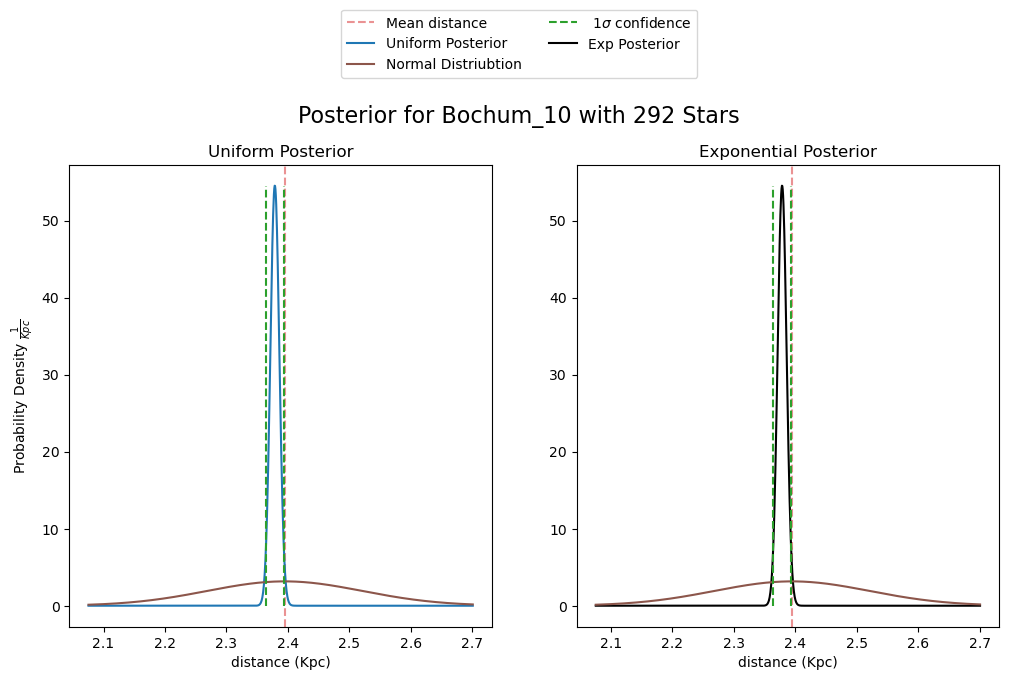

My cluster is Bochum_10
The Integrated posterior for a Normal Prior is 1.0 And for the Exponetial Prior is 1.0
Mode of Posterior pdf 2.378334934808336 Kpc
95% confidence interval for uniform prior = [2.36438511 2.39309053] Kpc
95% confidence interval for exponetial prior = [2.36437659 2.39308182] Kpc


In [12]:
def posterior(clusters, stars,cluster_name,samp, plotting, results):
    '''Calculate the posterior for distance to a cluster
    In log space
    From a random filtered cluster, sample its distance, mean and std dev
    use  Bayes' theorem to see if the data follows a gaussian

    The distance needs to be converted from parallax

    input: 
    cluster: pd dataframe of star clusters with more than 200 stars and low standard deviation
    star: pdf dataframe of the raw data
    
    Cluster_name - str Name of a cluster from cluster df
    samp- Boolean, if False sample all the stars if True sample 10 stars
    plotting- Boolean if true show the plot otherwise dont
    results - Boolean if true print the needed results otherwise dont

    variables
    dataset- all the data within stars of the randomly selected cluster
    parameters- get all the parameter space of the cluster to calculate the mean and std dev
    distance array - the distrance of the individual stars in the cluster
    lam_array - a sample of the distances 

    Pd_normal- the model evidence for a gaussian likelyhood and uniform prior
    Pd_exp- the model evidnece for a gaussian likelyhood and exponential prior
    
    '''
    #pick a random cluster from the cleaned dataset
    #rng = np.random.default_rng(rng_val) #for reproducability
    random_cluster = cluster_name
    #obtain all the data about the cluster
    #make a copy so that i dont get operation errors
    dataset = stars[stars['Name'] == random_cluster].copy()
    #gather all the parameters in the cluster 
    parameters = clusters.loc[random_cluster]
    #add offset to parallax units mas
    offset = 0.029 #mas 
    dataset['Plx'] = (dataset['Plx'] + offset) 
    #create a new column of distance to source
    dataset['Distance'] = 1/dataset['Plx'] # distance to star in kilo parsec
    #calculate the mean and std deviation after the offset
    mean_dist = dataset["Distance"].mean()
    std_dist = dataset['Distance'].std(numeric_only=True)

    e_plx = dataset['e_Plx']
    #for the uniform distribution prior
    uniform_distro = mean_dist
    #make sure the distances are an numpy array
    # either sample all the stars or 10 stars
    if samp == False:        
        distance_array = dataset['Distance'].to_numpy()
        #distance_array = np.linspace(0.6/np.max(dataset["Plx"]), 1./np.min(dataset['Plx']), num=1000)
    elif samp == True:
         distance_array = np.random.choice(dataset['Distance'].to_numpy(),size=10)
    #calculate the normal distribution for a cluster P(D| theta)

    #make a lambda array like that in episode 7 but for distance
    lam_array = np.linspace(np.min(distance_array), np.max(distance_array), num=1000)
    
    n_events = dataset["Plx"].to_numpy()
    #make a sample of random distributions around the distance to the cluster
    #loc is the mean and scale is the standard deviation

    #reshape the sample array
    reshape = n_events.reshape(len(n_events),1)
    plx_events = e_plx.to_numpy()
    reshape_eplx = plx_events.reshape(len(plx_events),1)

    #calculate the prior in logspace for each star and sum the total, convert back to normal space
    loglikel_prior = np.sum((sps.norm.logpdf(reshape, loc=1/lam_array, scale=reshape_eplx)),axis=0) + np.log(uniform_distro)
    likel_prior = np.exp(loglikel_prior-np.amax(loglikel_prior))
    #integrate the denominator
    Pd_normal = spint.simpson(likel_prior,x=lam_array)
    #posterior 
    normal_post = (likel_prior)/(Pd_normal)
    
    
    #repeat for the exponential prior call it "fancy" to aviod confusion with np.exp
    fancy_prior = realitstic_prior(d=lam_array)
    #copy and pasted the cod eabove and changed the prior
    fancy_loglikel_prior = np.sum((sps.norm.logpdf(reshape, loc=1/lam_array, scale=reshape_eplx)),axis=0) + np.log(fancy_prior)
    fancy_likel_prior = np.exp(fancy_loglikel_prior-np.amax(fancy_loglikel_prior))
    
    Pd_fancy = spint.simpson(fancy_likel_prior,x=lam_array)
    #exponetial distro posterior
    fancy_post = (fancy_likel_prior)/Pd_fancy

    #do a check with a nomral distribution
    #assuming mean and std dev is given by one value
    normal_distribution_cluster = sps.norm.pdf(x=lam_array, loc=mean_dist, scale=std_dist)

    #check area under the posterior = 1
    total_norm_post = spint.simpson(normal_post,x =lam_array)
    total_fancy_post = spint.simpson(fancy_post, x=lam_array)
    
    post_result = "The Integrated posterior for a Normal Prior is " +str(total_norm_post) + " And for the Exponetial Prior is "+str(total_fancy_post)

    #find the max posterior position
    #since they overlap i'll use the max of the exponential posterior
    #we also need it for assignment 4
    max_posterior = lam_array[np.argmax(fancy_post)]

    #confidence interval stuff
    #following phill's notes
    #for the noniform distiibution
    posterior_cdf_normal = spint.cumulative_trapezoid(normal_post,lam_array,initial=0)
    #invert the CDF
    posterior_ppf_normal = spinterp.interp1d(posterior_cdf_normal,lam_array)
    #define the confidence internval 
    int95_normal = posterior_ppf_normal([0.025,0.975])
    
    #Repeat for exponential
    posterior_cdf_fancy = spint.cumulative_trapezoid(fancy_post,lam_array,initial=0)
    #invert the CDF
    posterior_ppf_fancy= spinterp.interp1d(posterior_cdf_fancy,lam_array)
    #define the confidence internval 
    int95_fancy= posterior_ppf_fancy([0.025,0.975])


    #i asked chatgpt for this legend
    #fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
    if plotting: #if true
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        n_stars = len(distance_array) #number of sampled stars
        fig.suptitle('Posterior for '+random_cluster+" with "+str(n_stars)+' Stars', fontsize=16) 
        #mean plot line
        axes[0].axvline(x=mean_dist, alpha=0.5, c='tab:red', linestyle='--', label='Mean distance')
        axes[1].axvline(x=mean_dist, alpha=0.5, c='tab:red', linestyle='--')
        #normal posterior plot
        axes[0].set_title("Uniform Posterior")
        axes[0].plot(lam_array, normal_post,label="Uniform Posterior")
        axes[0].set_ylabel(r"Probability Density $\frac{1}{Kpc}$")
        axes[0].set_xlabel("distance (Kpc)")
        axes[1].set_xlabel("distance (Kpc)")
        #exponetial prior
        axes[1].set_title("Exponential Posterior")
        axes[1].plot(lam_array, fancy_post,color='k',label="Exp Posterior")
        axes[0].plot(lam_array, normal_distribution_cluster,label="Normal Distriubtion",color='tab:brown')
        axes[1].plot(lam_array, normal_distribution_cluster,color='tab:brown')
        
        axes[0].vlines(int95_normal,ymin=0,ymax=np.max(normal_post),color='tab:green',linestyle='dashed', label= r" 1$\sigma$ confidence")
        axes[1].vlines(int95_normal,ymin=0,ymax=np.max(fancy_post),color='tab:green',linestyle='dashed',)
        #i asked chatgpt for the legend
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
        plt.show()
    if results: #if true
        print("My cluster is " + random_cluster)
        print(post_result)
        print("Mode of Posterior pdf", max_posterior,"Kpc")
        print(r'95% confidence interval for uniform prior =',int95_normal,"Kpc")
        print(r'95% confidence interval for exponetial prior =',int95_fancy, "Kpc")

    
    return max_posterior 
post_result = posterior(cluster_analysis, stars,'Bochum_10',samp=False,plotting=True,results=True)


As part of requirement of bayes theorem, the  guess of the model input should not be modified, 
Can perfectly overlap since the weight of your guess diminishes for more and more datapoints <br>
Below i run the same code only for 10 random stars

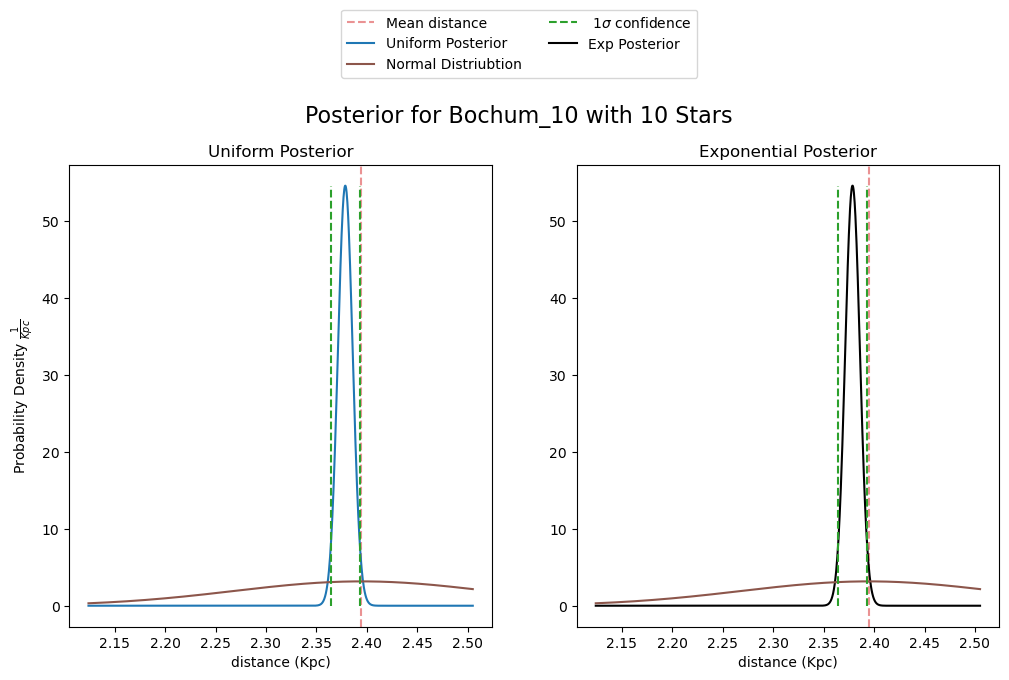

My cluster is Bochum_10
The Integrated posterior for a Normal Prior is 1.0000000000000002 And for the Exponetial Prior is 1.0
Mode of Posterior pdf 2.378784101107252 Kpc
95% confidence interval for uniform prior = [2.36439757 2.39307722] Kpc
95% confidence interval for exponetial prior = [2.36438954 2.39306838] Kpc


In [59]:
post_result = posterior(cluster_analysis, stars,'Bochum_10',samp=True,plotting=True,results=True)

# Q3 Discussion

# Q4
Now repeat the Bayesian distance calculation for all clusters used in the correlation sample in Task 2,
using only the more realistic, constant density exponentially decreasing prior. You should obtain the
distance estimate for each cluster from the maximum posterior probability of d. Then, use your
distances to correct these 4 observed quantities to the values they would have at a fixed distance of 1
kpc: σ& , σpos , δ̅, σ- . For these four corrected quantities, show the scatter-matrix plot and perform
Pearson and Spearman correlation tests. Comment on your results and how they differ compared to
what you obtained in Task 1 and 2 for the same quantities.

In [14]:
cluster_analysis.columns

Index(['Counts', 'Mean plx', 'Plx std', 'Cluster Size', 'Mean PM', 'PM Std'], dtype='object')

In [15]:
cluster_names = cluster_analysis.index

bayesian_distance = pd.DataFrame()
corrected_terms = cluster_analysis.copy()
for unique_cluster in cluster_names:
    max_posterior = posterior(cluster_analysis, stars,unique_cluster,samp=False,plotting=False,results=False)
    #df.append is outdated use pd.concat
    new_row = pd.DataFrame({'Name' : unique_cluster, 'Distance (Kpc)' : max_posterior}, index=[0])
    bayesian_distance = pd.concat([bayesian_distance, new_row], ignore_index=True)
    
    

/tmp/ipykernel_22538/297392649.py:4: RuntimeWarning: overflow encountered in exp
  return (d**2)*np.exp(-d/L)
/tmp/ipykernel_22538/297392649.py:4: RuntimeWarning: overflow encountered in multiply
  return (d**2)*np.exp(-d/L)
/tmp/ipykernel_22538/3582646756.py:81: RuntimeWarning: divide by zero encountered in log
  fancy_loglikel_prior = np.sum((sps.norm.logpdf(reshape, loc=1/lam_array, scale=reshape_eplx)),axis=0) + np.log(fancy_prior)
/tmp/ipykernel_22538/3582646756.py:82: RuntimeWarning: invalid value encountered in subtract
  fancy_likel_prior = np.exp(fancy_loglikel_prior-np.amax(fancy_loglikel_prior))
/tmp/ipykernel_22538/297392649.py:4: RuntimeWarning: overflow encountered in exp
  return (d**2)*np.exp(-d/L)
/tmp/ipykernel_22538/297392649.py:4: RuntimeWarning: overflow encountered in multiply
  return (d**2)*np.exp(-d/L)
/tmp/ipykernel_22538/3582646756.py:81: RuntimeWarning: divide by zero encountered in log
  fancy_loglikel_prior = np.sum((sps.norm.logpdf(reshape, loc=1/lam_arra

In [16]:
cluster_analysis.Counts

Name
BH_131         227
BH_140         338
BH_66          355
Berkeley_36    217
Berkeley_39    211
              ... 
UBC_461        231
UBC_517        256
UBC_600        390
UFMG_2         212
UFMG_38        246
Name: Counts, Length: 198, dtype: int64

In [17]:
terms_to_correct = cluster_analysis.copy().to_numpy()

In [18]:
terms_to_correct[:,5] #index 1 is mean plx, up to index5 pm std
corrector = bayesian_distance['Distance (Kpc)'].to_numpy()

corrected_plx = terms_to_correct[:,1] * corrector

#make a dataframe of the corrected terms, ignore counts
#correct for  plx std, cluster pos, mean pm and pm std

corrected_terms = pd.DataFrame({
    "Name" : cluster_analysis.index,
    "Counts" : cluster_analysis.Counts,
    "Mean plx" : terms_to_correct[:,1], # dont change
    "Plx std" : terms_to_correct[:,2] * corrector,
    "Cluster Size" : terms_to_correct[:,3] * corrector,
    "Mean PM" : terms_to_correct[:,4] * corrector,
    "PM Std" : terms_to_correct[:,5] * corrector

})
print("Corrected Dataframe")
corrected_terms

Corrected Dataframe


,Name,Counts,Mean plx,Plx std,Cluster Size,Mean PM,PM Std
Name,,,,,,,
BH_131,BH_131,227,0.125637,0.289579,1.389068,40.960452,0.967514
BH_140,BH_140,338,0.190195,-108.716210,-318.558924,-37242.615953,-324.113194
BH_66,BH_66,355,0.123089,0.287264,1.155370,34.951218,1.466230
Berkeley_36,Berkeley_36,217,0.217359,-95.466390,-91.655979,-2852.030831,-144.041585
Berkeley_39,Berkeley_39,211,0.226982,0.142586,0.169958,8.831151,0.255640
...,...,...,...,...,...,...,...
UBC_461,UBC_461,231,0.298768,0.095255,1.256795,12.281007,0.329332
UBC_517,UBC_517,256,0.405671,0.051938,1.641500,13.018769,0.291947
UBC_600,UBC_600,390,0.171171,0.190478,3.474879,5.738647,0.646746


# Make the scatter matrix  (incorrect one see below)
this one is incorrect i have to move to logspace, i just wanted to see if my function could work

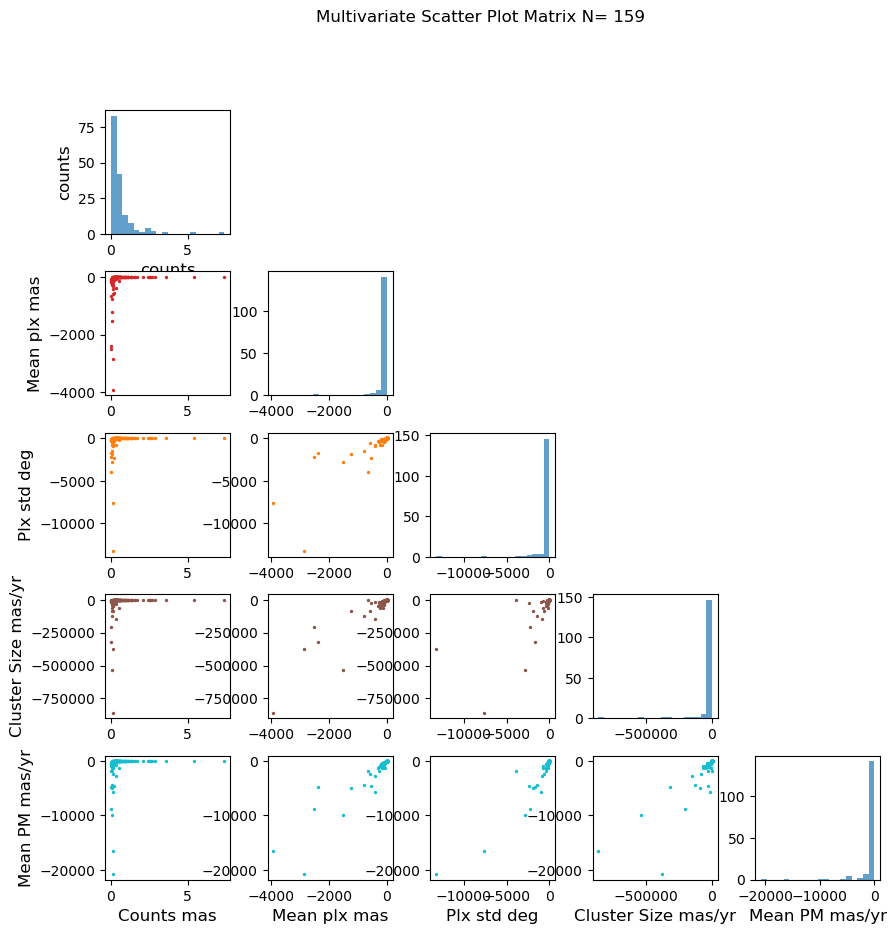

In [62]:
test = scatter_matrix(corrected_terms) 

# The Correct Scatter Matrix

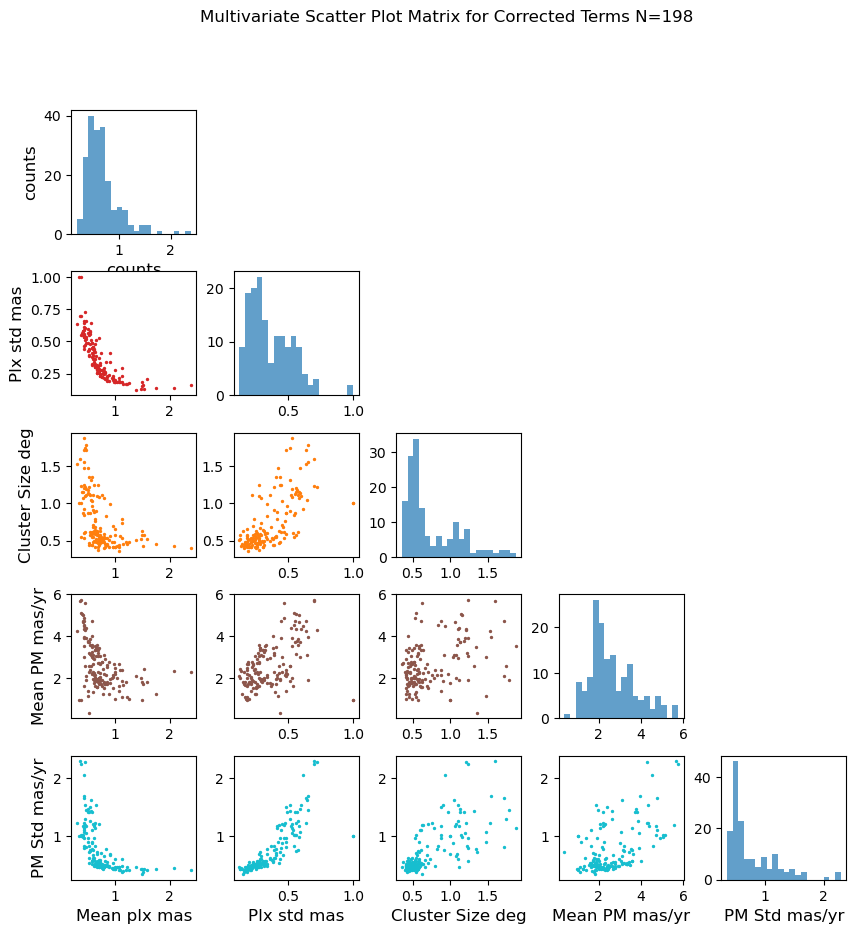

In [65]:
cluster = corrected_terms.fillna(1) # i have some NaN values in my dataframe, not sure how to fix
#replaced these with one
#skip name and counts column
labels= cluster.columns[2:] 
units = ['mas', 'mas','deg','mas/yr','mas/yr'] # add units to the labels
data = [cluster['Mean plx'], cluster['Plx std'], cluster['Cluster Size'], cluster['Mean PM'], cluster['PM Std']]
ndims = len(data)
fig, axes = plt.subplots(5,5,figsize=(10,10))
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle("Multivariate Scatter Plot Matrix for Corrected Terms N="+str(len(cluster)))
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:brown', 'tab:cyan']
for i in range(ndims): ## y dimension of grid
    for j in range(ndims): ## x dimension of grid
        if i == j:
            axes[i,j].hist(np.exp(np.log10(data[i])), bins=20,alpha=0.7,)
        elif i > j:
            axes[i,j].scatter(np.exp(np.log10(data[j])), np.exp(np.log10(data[i])),s=2, color=colors[i])
        else:
            axes[i,j].axis('off')
        if j == 0:
            if i == j:
                axes[i,j].set_xlabel('counts',fontsize=12)
                axes[i,j].set_ylabel('counts',fontsize=12)
            else:
                axes[i,j].set_ylabel(labels[i]+' '+units[i],fontsize=12)
        if i == 4:
            axes[i,j].set_xlabel(labels[j]+' '+units[j],fontsize=12)    
#fig.legend(labels=labels)
plt.show()

# Correlation Tests and Comments

In [25]:
corrected_terms.columns

Index(['Name', 'Counts', 'Mean plx', 'Plx std', 'Cluster Size', 'Mean PM',
       'PM Std'],
      dtype='object')

In [43]:
for i, cols1 in enumerate(cluster.columns[1:]): #skip counts column
    for j, cols2 in enumerate(cluster.columns[1:]):
        if i < j :
            pearson_corr, pearson_p_value, spearman_corr, spearman_p_value = correlation(cluster[cols1], cluster[cols2])
            print(f"{cols1} vs {cols2}: Pearson Correlation = {pearson_corr:.4f} (p-value = {pearson_p_value}), Spearman Correlation = {spearman_corr:.4f} (p-value = {spearman_p_value})")


Counts vs Mean plx: Pearson Correlation = -0.1325 (p-value = 0.06284798301707974), Spearman Correlation = -0.2838 (p-value = 5.076368326195594e-05)
Counts vs Plx std: Pearson Correlation = -0.3893 (p-value = 1.4350874598516195e-08), Spearman Correlation = -0.0854 (p-value = 0.2318395223503717)
Counts vs Cluster Size: Pearson Correlation = -0.6133 (p-value = 7.61703886821338e-22), Spearman Correlation = -0.0284 (p-value = 0.6909051408020003)
Counts vs Mean PM: Pearson Correlation = -0.3246 (p-value = 3.0669450710937237e-06), Spearman Correlation = -0.2189 (p-value = 0.0019470858811278648)
Counts vs PM Std: Pearson Correlation = -0.5793 (p-value = 3.882348769122466e-19), Spearman Correlation = -0.0302 (p-value = 0.6728081970789335)
Mean plx vs Plx std: Pearson Correlation = 0.1284 (p-value = 0.07150053967563019), Spearman Correlation = -0.0607 (p-value = 0.39579279260156186)
Mean plx vs Cluster Size: Pearson Correlation = 0.1017 (p-value = 0.15398526753507055), Spearman Correlation = 0.0